# Bayesian Linear regression vs Plugin approximation

In [74]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

try:
    import probml_utils as pml
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml
from probml_utils import savefig, latexify, is_latexify_enabled

try:
    from sklearn.linear_model import Ridge
except ModuleNotFoundError:
    %pip install -qq scikit-learn
    from sklearn.linear_model import Ridge
from scipy.stats import multivariate_normal

In [75]:
latexify(width_scale_factor=2)

/home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


## Generate Data

In [76]:
polydeg = 2  # Degree of design matrix
alph = 0.001  # Alpha of ridge regression
NFuncSamples = 10  # Number of sample coefficients to draw and use for prediction
vis = 0.5  # Transparency of plotted lines - in case we wish to plot a bunch.

# np.random.seed(0)
key = jax.random.PRNGKey(1)
xtrain = jnp.array([-3, -2, 0, 2, 3])
xtest = jnp.linspace(-7, 7, 141)
sigma2 = 25


def fun(x):
    return 10 + x + x**2


ytrain = fun(xtrain) + jax.random.normal(key=key, shape=[xtrain.shape[0]]) * jnp.sqrt(sigma2)
ytest = fun(xtest) + jax.random.normal(key=key, shape=[xtest.shape[0]]) * jnp.sqrt(sigma2)


def shp(x):
    return jnp.asarray(x).reshape(-1, 1)


xtrain = shp(xtrain)
xtest = shp(xtest)
ytrain = shp(ytrain)
ytest = shp(ytest)

In [77]:
def poly_basis(x, deg):
    # Expands a vector to a polynomial design matrix: from a constant to the deg-power
    return jnp.column_stack([x**deg for deg in range(0, deg + 1)])

## Train both models

In [78]:
xtrainp = poly_basis(xtrain, polydeg)
xtestp = poly_basis(xtest, polydeg)

# Declare and fit linear regression model
linreg = Ridge(alpha=alph, fit_intercept=False)
linreg.fit(xtrainp, ytrain)

# Determine coefficient distribution
wmle = linreg.coef_.reshape(
    -1,
)  # Mean of coefficients
wcov = sigma2 * jnp.linalg.inv(
    jnp.diag(jnp.array([alph] * (polydeg + 1))) + xtrainp.T.dot(xtrainp)
)  # Covariance of coefficients
posterior_bayes = multivariate_normal(mean=wmle, cov=wcov)
samples = posterior_bayes.rvs(NFuncSamples)

# Sample predictions according to samples of coefficients
prediction_samples = xtestp.dot(samples.T)

ypred_mle = linreg.predict(xtestp)  # MLE prediction
noise_mle = jnp.var(ytrain - linreg.predict(xtrainp), ddof=(polydeg + 1))  # MLE noise estimation

## Plotting

In [79]:
def make_plot(ypreds, save_name, title, lowerb=None, upperb=None):
    # Function for creating and saving plots
    fig, ax = plt.subplots()
    if not is_latexify_enabled():
        SCATTER_SIZE = 140
    else:
        SCATTER_SIZE = 40

    ax.scatter(xtrain, ytrain, s=SCATTER_SIZE, facecolors="none", edgecolors="r", label="training data")

    # plt.ylim([-10,80])
    # plt.xlim([-8,8])
    errlogi = lowerb is not None or upperb is not None  # Determines where we will be plotting error bars as well
    if errlogi:
        errspacing = [int(round(s)) for s in jnp.linspace(0, xtest.shape[0] - 1, 30)]
        errspacing_reshaped = jnp.reshape(jnp.array(errspacing), (1, len(errspacing)))
        yerr = [list(lowerb[jnp.array(errspacing)]), list(upperb[jnp.array(errspacing)])]
        ax.errorbar(
            xtest[errspacing_reshaped][0, :, :],
            ypreds[jnp.array(errspacing), 0],
            yerr=yerr,
            linewidth=0.5,
            label="prediction",
        )
        ax.fill_between(xtest[:, 0], ypreds[:, 0] + lowerb, ypreds[:, 0] - upperb, alpha=0.3)
    else:
        for j in range(ypreds.shape[1]):
            ax.plot(xtest, ypreds[:, j], color="k", linewidth=1.0, label="prediction", alpha=vis)
    #     if errlogi:
    plt.legend(loc=9, prop={"size": 7})

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    #     plt.title(title)
    pml.savefig(save_name + "_latexified")

/home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


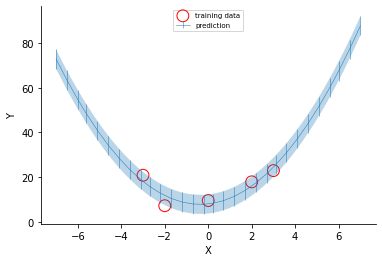

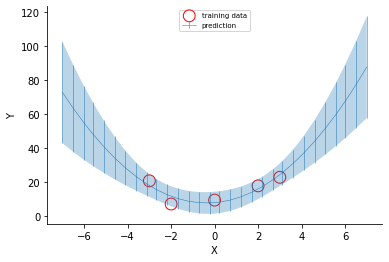

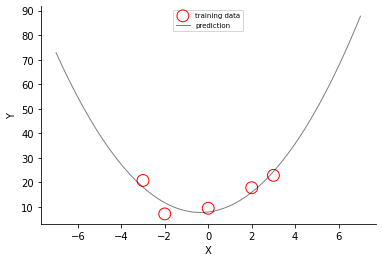

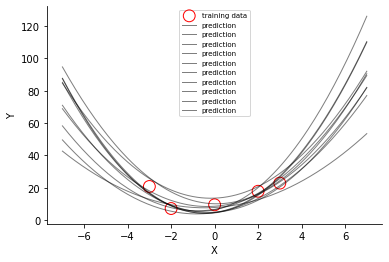

In [80]:
# plot a
noisevec = jnp.array([jnp.sqrt(noise_mle)] * ypred_mle.shape[0])
make_plot(ypred_mle, "linregPostPredPlugin", "Plugin approximation", noisevec, noisevec)

# plot b
postnoise = jnp.array([jnp.sqrt(sigma2 + xtestp[i, :].T.dot(wcov.dot(xtestp[i, :]))) for i in range(xtestp.shape[0])])
make_plot(ypred_mle, "linregPostPredBayes", "Posterior predictive", postnoise, postnoise)

# plot c
make_plot(ypred_mle, "linregPostPredSamplesPlugin", "functions sampled from plugin approximation to posterior")

# plot d
make_plot(prediction_samples, "linregPostPredSamples", "functions sampled from posterior")
plt.show()